In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import cv2
from torch.distributions import Normal, Uniform
from torch.distributions.kl import kl_divergence
from torch.nn import functional as F

from spair import debug_tools
from spair.modules import stn




In [1]:

B = 20
H = 10
W = 11
Context = 30

t = torch.arange(B * H * W * Context)
t2 = t.reshape(B, H, W, Context)

t3 = t2[:, 2:5, 2:5, ...]
t4 = t3.contiguous().view(B, 9, Context)
t4.shape


torch.Size([20, 9, 30])

In [14]:

range = 5

cols = np.arange(-range, range) 
rows = np.arange(-range, 1) # previous visited rows, including current row
mesh = np.meshgrid(cols, rows)
rotated = np.array(mesh).T
flattened = np.reshape(rotated, (-1, 2))  # flattens 
coords = flattened[:-range, :] # A list of coords 


In [98]:


# Testing if sliding index could 
x = torch.tensor(np.ones((3,3)) * 3., requires_grad=True)

x2 = torch.tensor(np.ones((2,2)) * 2, requires_grad=True)
x3 = torch.tensor(1., requires_grad=True)
y = torch.tensor(np.ones((5,5)) * 5, requires_grad=False)
y[:3,:3] = x 
y[3:,3:] += x2
y[4,2] = x3

v = torch.ones(5, 5, dtype=torch.double) * 0.001


# Testing frozen gradients
g = 0.6

y = g * y.detach() + (1-g) * y

out = y * 100
out.backward(v)

print('x grad', x.grad)
print('x2 grad', x2.grad)
print('x3 grad', x3.grad)
print(v)



x grad tensor([[0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400],
        [0.0400, 0.0400, 0.0400]], dtype=torch.float64)
x2 grad tensor([[0.0400, 0.0400],
        [0.0400, 0.0400]], dtype=torch.float64)
x3 grad tensor(0.0400)
tensor([[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010, 0.0010, 0.0010]], dtype=torch.float64)


Testing Distribution stuff



In [179]:
means = torch.randn(5,5)
sigmas  = torch.randn(5,5) 
q = Normal(loc=means, scale=sigmas)
#q = q.rsample()[None,...]

p = Normal(loc=5, scale=1)
#p = p.rsample()[None,...]

z = kl_divergence(q, p)
print(z)
print(p)
print(q)
#print(q.log())


tensor([[16.8388,  8.8837, 21.1495,  8.7082, 12.4242],
        [14.4011,  7.4555, 21.8633,  9.5328, 13.6611],
        [13.8057, 26.1755,  8.2373, 10.1558,  7.3999],
        [14.4117, 11.7476, 14.8190,  7.4312,  5.0163],
        [22.2008, 14.0156,  5.7998, 15.3988,  6.7364]])
Normal(loc: 5.0, scale: 1.0)
Normal(loc: torch.Size([5, 5]), scale: torch.Size([5, 5]))


Testing SNT


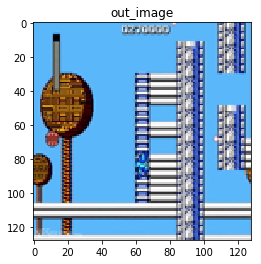

In [20]:
img_BGR = cv2.imread('spair/data/testimg.png')
img = img_BGR[..., ::-1].astype(np.float) # BGR to RGB
img /= 255. # color space [0, 1]
img = torch.from_numpy(np.array([np.moveaxis(img, [0,1,2], [1,2,0])], dtype=np.float32))

debug_tools.plot_stn_input_and_out(img)



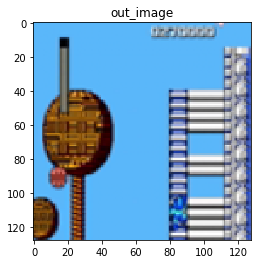

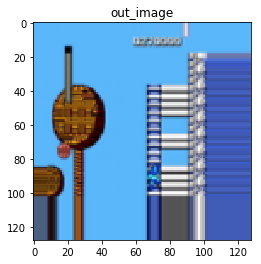

In [39]:
z_where = torch.tensor([0, 0, 0.75, 0.75])
out_dim = [128, 128]

out_img = stn(img, z_where, out_dim )
debug_tools.plot_stn_input_and_out(out_img)

out_dim = [128, 128]
out_img_inverse = stn(out_img, z_where, out_dim, inverse=True)
debug_tools.plot_stn_input_and_out(out_img_inverse)


In [38]:
def stn(image, z_where, output_dims, inverse=False):
    """
    Slightly modified based on https://github.com/kamenbliznashki/generative_models/blob/master/air.py

    spatial transformer network used to scale and shift input according to z_where in:
            1/ x -> x_att   -- shapes (H, W) -> (attn_window, attn_window) -- thus inverse = False
            2/ y_att -> y   -- (attn_window, attn_window) -> (H, W) -- thus inverse = True
    inverting the affine transform as follows: A_inv ( A * image ) = image
    A = [R | T] where R is rotation component of angle alpha, T is [tx, ty] translation component
    A_inv rotates by -alpha and translates by [-tx, -ty]
    if x' = R * x + T  -->  x = R_inv * (x' - T) = R_inv * x - R_inv * T
    here, z_where is 3-dim [scale, tx, ty] so inverse transform is [1/scale, -tx/scale, -ty/scale]
    R = [[s, 0],  ->  R_inv = [[1/s, 0],
         [0, s]]               [0, 1/s]]
    """

    # TODO Test stn
    yt, xt, ys, xs = torch.chunk(z_where, 4, dim=-1)
    yt = yt.squeeze()
    xt = xt.squeeze()
    ys = ys.squeeze()
    xs = xs.squeeze()

    batch_size = image.shape[0]
    out_dims = [batch_size, 3] + output_dims # [Batch, RGB, obj_h, obj_w]

    # yt/xt give top/left but here we need center
    #yt += (ys / 2)  # TODO ? Why multiply by 2, to upsample?
    yt = (yt + (ys / 2)) * 2 - 1
    xt = (xt + (xs / 2)) * 2 - 1

    # TODO  Clarification on the resampling process.

    theta = torch.zeros(2, 3).repeat(batch_size, 1, 1)

    if inverse:
        xs = 1/xs
        ys = 1/ys
        yt = -yt / (ys + 1e-9)
        xt = - xt / (xs + 1e-9)
        out_dims = [batch_size, 4] + output_dims  # [Batch, RGBA, obj_h, obj_w]

    # set scaling
    theta[:, 0, 0] = xs  # TODO This scaling might not be compatible with pytorch affine_Grid
    theta[:, 1, 1] = ys
    # set translation
    theta[:, 0, -1] = xt
    theta[:, 1, -1] = yt

    # 2. construct sampling grid
    grid = F.affine_grid(theta, out_dims)

    # 3. sample image from grid
    input_glimpses = F.grid_sample(image, grid, padding_mode='border')
    # debug_tools.plot_stn_input_and_out(input_glimpses)


    return input_glimpses

In [34]:


inp = np.ones([1, 128, 128, 3])

layers = [
    dict(filters=128, kernel_size=4, stride=3),
    dict(filters=128, kernel_size=4, stride=2),
    dict(filters=128, kernel_size=4, stride=2),
    dict(filters=128, kernel_size=1, stride=1),
    dict(filters=128, kernel_size=1, stride=1),
    dict(filters=128, kernel_size=1, stride=1),
]
n_grid_dims = 2 
# ndim = len([batch, 50, 50, 3]) - 2 = 2
ndim = len(inp.shape) - 2 
j = np.array((1,)*ndim) # [1, 1]
r = np.array((1,)*ndim)
receptive_fields = []

for layer in layers:
    kernel_size = np.array(layer['kernel_size']) # for each layer, [4, 4, 4, 1, .. ]
    stride = np.array(layer['stride']) # for each layer, [3, 2, 2, 1, .. ]
    r = r + (kernel_size-1) * j # starts at [1, 1] + 3 * [1,1]
    j = j * stride # cumulative ratio 
    receptive_fields.append(dict(size=r, translation=j))


# computes the output layer's ratio to input layer 
grid_cell_size = receptive_fields[-1]["translation"][:n_grid_dims] 

# compute the output layer's absolute size 
rf_size = receptive_fields[-1]["size"][:n_grid_dims]

pre_padding = np.floor(rf_size / 2 - grid_cell_size / 2).astype('i')

image_shape = np.array([int(i) for i in inp.shape[1:n_grid_dims+1]])

n_grid_cells = np.ceil(image_shape / grid_cell_size).astype('i')

required_image_size = rf_size + (n_grid_cells-1) * grid_cell_size

post_padding = required_image_size - image_shape - pre_padding

print("rf_size: {}".format(rf_size))
print("grid_cell_size: {}".format(grid_cell_size))
print("n_grid_cells: {}".format(n_grid_cells))
print("pre_padding: {}".format(pre_padding))
print("post_padding: {}".format(post_padding))
print("required_image_size: {}".format(required_image_size))

print(n_grid_cells)
print(grid_cell_size)


rf_size: [31 31]
grid_cell_size: [12 12]
n_grid_cells: [11 11]
pre_padding: [9 9]
post_padding: [14 14]
required_image_size: [151 151]
[11 11]
[12 12]
